**Disclaimer: Do NOT use anything you find in here to help you choose a mushroom!**

This notebook explores the tradeoff between type 1 (false positive) and type 2 (false negative) errors. In this example, we are attempting to determine whether a given mushroom is edible. In this context a *false positive* is a deadly mushroom classified as edible (BAD!) and a false negative is is an edible mushroom classified as poisonous (a shame, but ok).

For what follows, suppose we determine (unrealistically!) that we are OK if 1 out of every 100 
mushrooms that we eat is poisonous. This is mental, but it's the kind of constraint that has to 
come from outside the modelling process and so the exact value is not our concern here.
To be explicit, we are tying to build the best model that has a **false positive rate (type 1 error rate) of 1% or less**.

Start with some imports:

In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import warnings

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

import seaborn as sns
import matplotlib.pyplot as plt
colors = sns.dark_palette("gray", n_colors=5)
sns.set_palette(colors)

As we will see, the data are too easy and an untuned decision tree is able to achieve
perfect accuracy on unseen data. The function below loads the data and flips the labels
of a given proportion of samples to make the problem more difficult.

In [2]:
def load_data(noise_level):
    path = kagglehub.dataset_download("uciml/mushroom-classification")
    df = pd.read_csv(os.path.join(path, "mushrooms.csv"))
    assert df.isna().sum().sum() == 0, f"Expected no missing values, got {df.isna().sum().sum()}"
    assert set(df['class']) == {'e', 'p'}, f"Unexpected values in class column: {set(df['class'])}"
    df['class'] = (df['class'] == 'e').astype(int)

    if noise_level > 0: 
        # Polute the data to make the problem harder. 
        mask = np.random.random(len(df)) < noise_level
        df.loc[mask, 'class'] = 1 - df.loc[mask, 'class']
    
    train, test = train_test_split(df, train_size=0.7)
    train, valid = train_test_split(train, train_size=0.7)
    return train, valid, test

## The Data
The data contain many qualitative features of mushrooms, which will need to be one hot encoded for 
the models that we are building. A few of the features are listed below.

| Attribute | Values |
|----------------------------------|--------------------------------------------------------------------------------------------|
| Cap Shape | bell (b), conical (c), convex (x), flat (f), knobbed (k), sunken (s) |
| Cap Surface | fibrous (f), grooves (g), scaly (y), smooth (s) |
| Cap Color | brown (n), buff (b), cinnamon (c), ... |
| Bruises | bruises (t), no (f) |

We define a reusable pipeline generator that takes the data and a base classifier and returns
a trainable object that also encodes the input features.

In [3]:
def make_pipeline(data, classifier):
    y = data['class']
    X = data.drop('class', axis=1)

    column_transformer = ColumnTransformer(
        transformers=[
            # Somewhat over-engineered since all columns are transformed the same way...
            ('encoder', OneHotEncoder(drop='first', handle_unknown='ignore'), X.columns)
        ],
        remainder='passthrough'
    )

    # Silence warnings about features encountered in prediction that were not seen during training.
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        return Pipeline(steps=[
            ('preprocessor', column_transformer),
            ('classifier', classifier)
        ]).fit(X, y)

The following experiment shows that the dataset is too easy.
If we train an untuned decision tree we can achive perfect accuracy on unseen data.

In [4]:
def no_noise():
    """
    Train a decision tree classifier and return prediction accuracy on
    the validation set.
    """
    df, df_valid, _ = load_data(noise_level=0)
    pipe = make_pipeline(df, DecisionTreeClassifier())
    y_hat = pipe.predict(df_valid.drop('class', axis=1))
    return np.mean(y_hat == df_valid['class'])

no_noise()

np.float64(1.0)

Fix the noise level at 0.1 and split off training, validation and final test data sets.

In [5]:
df_train, df_valid, df_test = load_data(0.1)

In [6]:
def plot_confusion(model, data, threshold, ax):
    y_pred = model.predict_proba(data.drop('class', axis=1))[:, 1] > threshold
    y_true = data['class']

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d',
        cmap=colors,
        xticklabels=['poisonous', 'edible'],
        yticklabels=['poisonous', 'edible'], 
        ax=ax,
        cbar=False
    )
    ax.set(ylabel='True Label', xlabel='Predicted Label', title="Confusion Matrix")

def plot_roc(model, data, threshold, ax):
    y_score = model.predict_proba(data.drop('class', axis=1))[:, 1]
    y_true = data['class']

    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    ax.plot(
        fpr, 
        tpr, 
        lw=1,
        label=f'ROC curve (AUC = {roc_auc:.2f})'
    )
    ax.plot(
        [0, 1], 
        [0, 1], 
        lw=1, 
        linestyle='--',
        label='Random classifier'
    )

    closest_threshold_idx = np.argmin(np.abs(thresholds - threshold))
    threshold_fpr = fpr[closest_threshold_idx]
    threshold_tpr = tpr[closest_threshold_idx]

    ax.plot(
        threshold_fpr, 
        threshold_tpr, 
        marker='o', 
        markersize=4, 
        label=f'Threshold = {threshold:.2f}'
    )

    ax.set(xlim=[0.0, 1.0], ylim=[0, 1.05])
    ax.set(xlabel='FPR (Poisonous classified as Edible)')
    ax.set(ylabel='TPR (Edible correctly classified)')
    ax.set(title="Receiver Operating Curve")
    ax.legend(loc="lower right")

    
def plot_prediction_histogram(model, data, ax):
    sns.histplot(
        model.predict_proba(data.drop('class', axis=1))[:, 1],
        bins=30,
        alpha=0.6,
        ax=ax,
    )
    ax.set(title = "Histogram of Predictions")

## Baseline
As a baseline model, we can take a simple logistic regression and see how it goes. 
Note that the point here is not to get the absolute best model, but to experiment
with type 1 and type 2 error rates.

In this version, if the model thinks that a mushroom is more than 50% likely to be 
poisonous then it will classify it as such. This model does not achieve the required
false positive rate, but it's a useful start to put things in context.

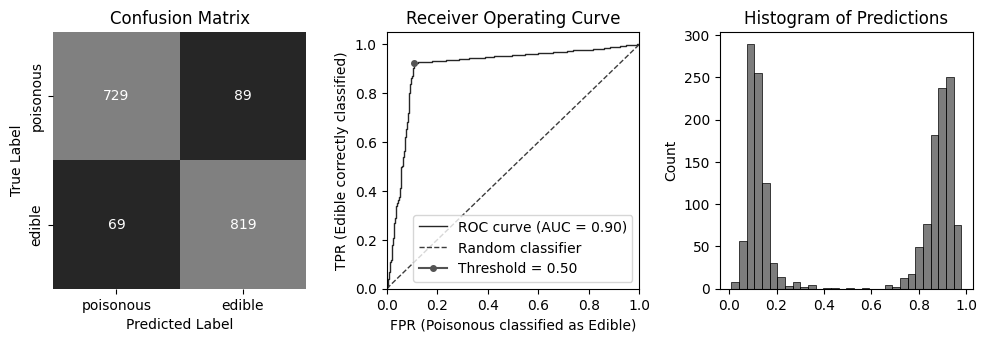

In [7]:
def model_baseline():
    model = make_pipeline(df_train, LogisticRegression())
    _, axs = plt.subplots(ncols=3, nrows=1, figsize=(10, 3.5))

    threshold = 0.5
    plot_confusion(model, df_valid, threshold, ax=axs[0])
    plot_roc(model, df_valid, threshold, axs[1])
    plot_prediction_histogram(model, df_valid, axs[2])

    plt.tight_layout(pad=1)
    plt.show()

model_baseline()

## Tighter Decision Threshold
The first strategy to try is to make the decision threshold more and more conservative
until we achieve the desired false positive rate. The following code shows that if we 
eat a mushroom only if we are $93\%$ sure that it's safe (as opposed to any number greater 
than $50\%$) then we achieve our desired $1\%$ false positive rate and end up with $63$ edible 
mushrooms.

Using threshold: 0.95


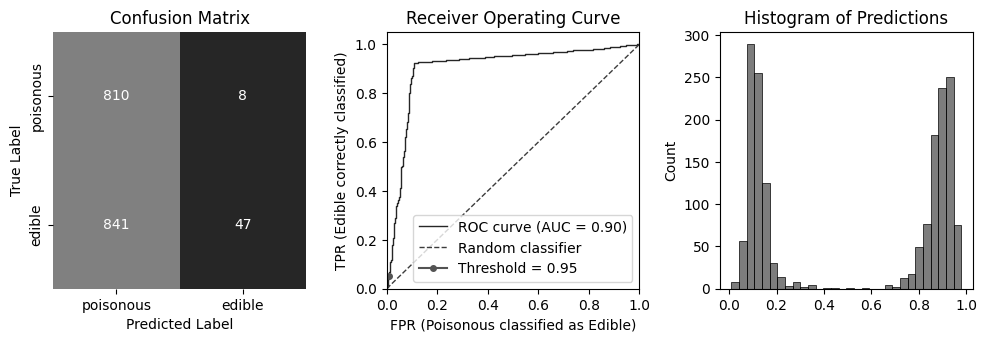

In [8]:
def model_threshold():
    model = make_pipeline(df_train, LogisticRegression())
    
    # Get model predictions
    y_score = model.predict_proba(df_valid.drop('class', axis=1))[:, 1]
    y_true = df_valid['class']
    
    # Calculate ROC curve points
    fpr, _tpr, thresholds = roc_curve(y_true, y_score)
    
    # Find threshold that gives us FPR ≤ 1%
    target_fpr = 0.01
    valid_thresholds = thresholds[fpr <= target_fpr]
    if len(valid_thresholds) > 0:
        # Take the smallest valid threshold (gives best TPR while maintaining FPR ≤ 1%)
        threshold = valid_thresholds[-1]
    else:
        # If no threshold achieves target FPR, take the most conservative threshold
        threshold = thresholds.max()
    
    print(f"Using threshold: {threshold:.2f}")
    
    # Plot results
    _, axs = plt.subplots(ncols=3, nrows=1, figsize=(10, 3.5))
    
    plot_confusion(model, df_valid, threshold, ax=axs[0])
    plot_roc(model, df_valid, threshold, axs[1])
    plot_prediction_histogram(model, df_valid, axs[2])

    plt.tight_layout(pad=1)
    plt.show()

model_threshold()

## Class Weights
A second strategy would be to increase the penalty during training of a 
poisonous mushroom being incorrectly classified (as edible). In scikit
learn this is relatively easy to implement.  The main problem with this
approach is that it's hard to say what the right ratio of penalties should
be for misclassifying a poisonous or edible mushroom.  The ratio is fed into
the training routine of the model, which will vary as we try different model 
families. This makes it a very difficult parameter to interpret. 
Nevertheless, let's pick a cost ratio of $5$ out of nowhere.

Using cost ratio: 5
Optimal threshold: 0.80


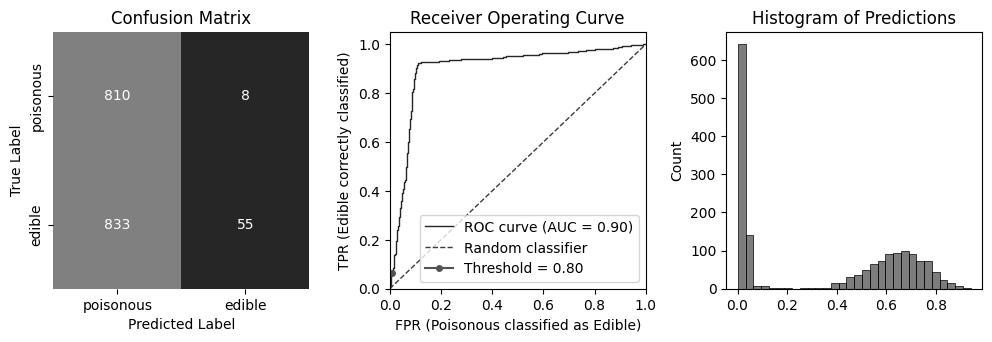

In [9]:
def model_weights_and_threshold():

    # Suppose we start with a vague notion that a false positive should be penalised,
    # but we don't really know by how much.
    classifier = LogisticRegression(class_weight={0: 5, 1:1})
    print("Using cost ratio: 5")

    model = make_pipeline(df_train, classifier)
    
    y_score = model.predict_proba(df_valid.drop('class', axis=1))[:, 1]
    y_true = df_valid['class']
    
    fpr, _tpr, thresholds = roc_curve(y_true, y_score)
    
    # Find threshold that gives us FPR ≤ 1%
    target_fpr = 0.01
    valid_thresholds = thresholds[fpr <= target_fpr]
    if len(valid_thresholds) > 0:
        # Take the smallest valid threshold (gives best TPR while maintaining FPR ≤ 1%)
        threshold = valid_thresholds[-1]
    else:
        # If no threshold achieves target FPR, take the most conservative threshold
        threshold = thresholds.max()
    
    print(f"Optimal threshold: {threshold:.2f}")
    
    _, axs = plt.subplots(ncols=3, nrows=1, figsize=(10, 3.5))
    
    plot_confusion(model, df_valid, threshold, ax=axs[0])
    plot_roc(model, df_valid, threshold, axs[1])
    plot_prediction_histogram(model, df_valid, axs[2])

    plt.tight_layout(pad=1)
    plt.show()

model_weights_and_threshold()

This gives us more edible mushrooms!

## Optimal Cost Ratio

As a last try we can adjust the cost ratio used during training dynamically to 
find the one that will give us the desired false positive rate. 
For a bit of extra work (a binary search for the the right cost ratio) you get the 
same results as the previous method.

Optimal cost ratio: 23
Using threshold: 0.50


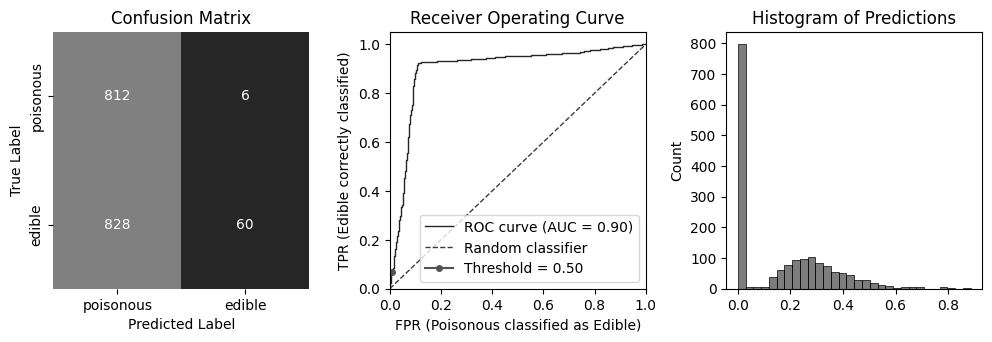

In [10]:
def model_weights():
    
    def get_false_positive_rate(cost_ratio):
        classifier = LogisticRegression(
            class_weight={0: cost_ratio, 1: 1}
        )
        model = make_pipeline(df_train, classifier)
        
        # Get predictions
        y_pred = model.predict(df_valid.drop('class', axis=1))
        y_true = df_valid['class']
        
        # Calculate confusion matrix
        tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
        
        # False positive rate = FP / (FP + TN)
        fpr = fp / (fp + tn)
        return fpr, model
    
    # Binary search for smallest ratio that achieves FPR < 1%
    left, right = 1, 1000
    best_ratio = right
    best_model = None
    target_fpr = 0.01
    
    while left <= right:
        mid = (left + right) // 2
        fpr, model = get_false_positive_rate(mid)
        
        if fpr <= target_fpr:
            # This ratio works, but maybe we can do better
            best_ratio = mid
            best_model = model
            right = mid - 1
        else:
            # Need a higher ratio
            left = mid + 1
    
    print(f"Optimal cost ratio: {best_ratio}")
    
    # Plot results with optimal ratio
    _, axs = plt.subplots(ncols=3, nrows=1, figsize=(10, 3.5))
    
    threshold = 0.5
    print(f"Using threshold: {threshold:.2f}")

    plot_confusion(best_model, df_valid, threshold, ax=axs[0])
    plot_roc(best_model, df_valid, threshold, axs[1])
    plot_prediction_histogram(best_model, df_valid, axs[2])
    
    plt.tight_layout(pad=1)
    plt.show()

model_weights()